In [3]:
import pandas as pd
import os
os.chdir('/Users/hanliyang/Documents/GitHub/Parkinson-Prediagnosis')

In [8]:
import pandas as pd


df = pd.read_csv('Paper/Materia_Data/elbow_rom_synthetic.csv')  # your file

gait_cycle = df['Gait_Cycle(%)']
patient_mean = df['Patient_Mean']
patient_std = df['Patient_Std']
reference_mean = df['Reference_Mean']
reference_std = df['Reference_Std']

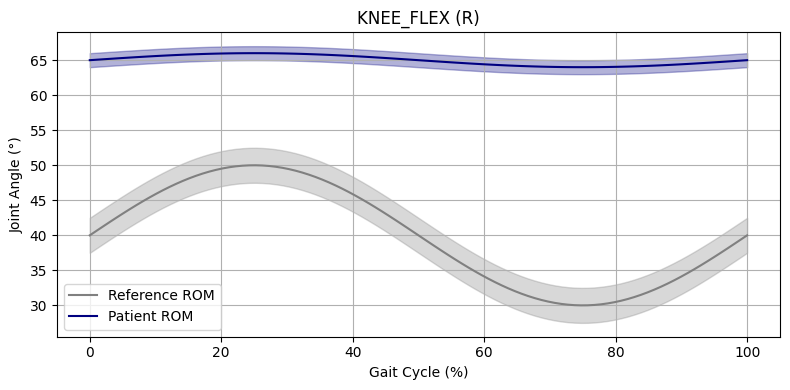

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(8, 4))

# Reference ROM (gray)
plt.plot(gait_cycle, reference_mean, label='Reference ROM', color='gray')
plt.fill_between(gait_cycle, reference_mean - reference_std, reference_mean + reference_std,
                 color='gray', alpha=0.3)

# Patient ROM (blue)
plt.plot(gait_cycle, patient_mean, label='Patient ROM', color='navy')
plt.fill_between(gait_cycle, patient_mean - patient_std, patient_mean + patient_std,
                 color='navy', alpha=0.3)

plt.xlabel('Gait Cycle (%)')
plt.ylabel('Joint Angle (°)')
plt.title('KNEE_FLEX (R)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Synthetic, cyclic-smoothed ROM data saved to rom_data_synthetic_smoothed.csv


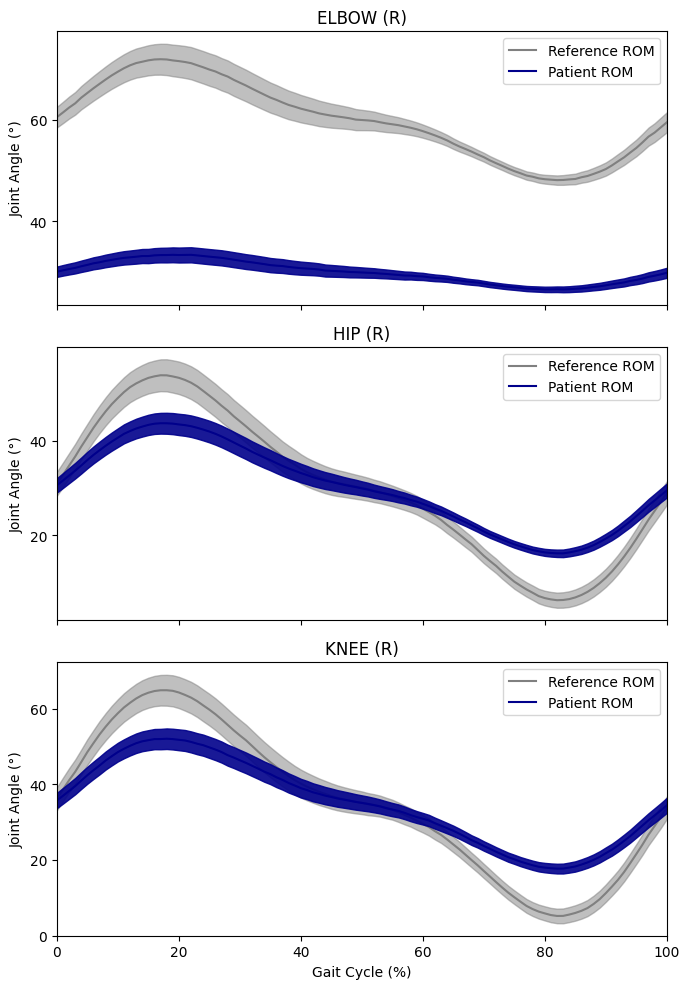

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# 1) DATA GENERATION
###############################################################################

# Create a gait cycle from 0 to 100% (101 points)
gait_cycle = np.linspace(0, 100, 101)

def random_wave(gait, baseline, amp_main, amp_second, noise_scale=0.3):
    """
    Combine two sine waves + random noise for a more 'irregular' mean curve.
    The wave is naturally periodic over 0-100, but random noise can cause
    discontinuities at edges (which we'll smooth out later).
    """
    wave = (baseline
            + amp_main   * np.sin(2 * np.pi * gait / 100)   # 1st harmonic
            + amp_second * np.sin(4 * np.pi * gait / 100)   # 2nd harmonic
            + noise_scale * np.random.randn(len(gait)))     # random noise
    return wave

def variable_std(gait, base_std, amp_std):
    """
    Create a variable standard deviation curve over the gait cycle,
    ensuring no negative or tiny values.
    """
    std_vals = base_std + amp_std * np.sin(2 * np.pi * gait / 100)
    return np.clip(std_vals, 0.2, None)

def smooth_cyclic(data, window_len=7):
    """
    Smooth data in a 'cyclic' way so that the start and end points match up,
    preventing weird edge behavior after smoothing.
    """
    half = window_len // 2
    # Wrap-around padding
    extended = np.concatenate([data[-half:], data, data[:half]])
    kernel = np.ones(window_len) / window_len
    smoothed_ext = np.convolve(extended, kernel, mode='same')
    # Remove the padded parts
    smoothed = smoothed_ext[half:-half]
    return smoothed

# -----------------------------------------------------------------------------
# ELBOW (R) -- smaller Patient ROM, bigger Reference
# -----------------------------------------------------------------------------
elbow_ref_mean = random_wave(gait_cycle, baseline=60, amp_main=10, amp_second=4, noise_scale=0.3)
elbow_ref_std  = variable_std(gait_cycle, base_std=2.0, amp_std=1.2)

elbow_pat_mean = random_wave(gait_cycle, baseline=60, amp_main=3,  amp_second=1, noise_scale=0.2)
elbow_pat_std  = variable_std(gait_cycle, base_std=1.0, amp_std=0.5)

# Smooth them cyclically
elbow_ref_mean = smooth_cyclic(elbow_ref_mean, window_len=7)
elbow_ref_std  = smooth_cyclic(elbow_ref_std,  window_len=7)
elbow_pat_mean = smooth_cyclic(elbow_pat_mean, window_len=7)
elbow_pat_std  = smooth_cyclic(elbow_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# HIP (R)
# -----------------------------------------------------------------------------
hip_ref_mean = random_wave(gait_cycle, baseline=30, amp_main=20, amp_second=8, noise_scale=0.3)
hip_ref_std  = variable_std(gait_cycle, base_std=2.5, amp_std=1.0)

hip_pat_mean = random_wave(gait_cycle, baseline=30, amp_main=12, amp_second=4, noise_scale=0.2)
hip_pat_std  = variable_std(gait_cycle, base_std=1.5, amp_std=0.8)

hip_ref_mean = smooth_cyclic(hip_ref_mean, window_len=7)
hip_ref_std  = smooth_cyclic(hip_ref_std,  window_len=7)
hip_pat_mean = smooth_cyclic(hip_pat_mean, window_len=7)
hip_pat_std  = smooth_cyclic(hip_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# KNEE (R)
# -----------------------------------------------------------------------------
knee_ref_mean = random_wave(gait_cycle, baseline=35, amp_main=25, amp_second=10, noise_scale=0.4)
knee_ref_std  = variable_std(gait_cycle, base_std=3.0, amp_std=1.2)

knee_pat_mean = random_wave(gait_cycle, baseline=35, amp_main=15, amp_second=5, noise_scale=0.3)
knee_pat_std  = variable_std(gait_cycle, base_std=2.0, amp_std=0.8)

knee_ref_mean = smooth_cyclic(knee_ref_mean, window_len=7)
knee_ref_std  = smooth_cyclic(knee_ref_std,  window_len=7)
knee_pat_mean = smooth_cyclic(knee_pat_mean, window_len=7)
knee_pat_std  = smooth_cyclic(knee_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# 2) SAVE TO CSV
# -----------------------------------------------------------------------------
df = pd.DataFrame({
    "Gait_Cycle(%)": gait_cycle,

    "Elbow_Reference_Mean": elbow_ref_mean,
    "Elbow_Reference_Std":  elbow_ref_std,
    "Elbow_Patient_Mean":   elbow_pat_mean,
    "Elbow_Patient_Std":    elbow_pat_std,

    "Hip_Reference_Mean":   hip_ref_mean,
    "Hip_Reference_Std":    hip_ref_std,
    "Hip_Patient_Mean":     hip_pat_mean,
    "Hip_Patient_Std":      hip_pat_std,

    "Knee_Reference_Mean":  knee_ref_mean,
    "Knee_Reference_Std":   knee_ref_std,
    "Knee_Patient_Mean":    knee_pat_mean,
    "Knee_Patient_Std":     knee_pat_std
})

# Compute the current mean of the Elbow Patient data
current_mean = df['Elbow_Patient_Mean'].mean()
# Choose a target mean, for instance 30 (midpoint of 20 and 40)
target_mean = 30
offset = current_mean - target_mean

# Subtract the offset to shift the blue line downward
df['Elbow_Patient_Mean'] = df['Elbow_Patient_Mean'] - offset

csv_filename = "rom_data_synthetic_smoothed.csv"
df.to_csv(csv_filename, index=False)
print(f"Synthetic, cyclic-smoothed ROM data saved to {csv_filename}")

###############################################################################
# 3) PLOT THE RESULTS
###############################################################################
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

def plot_joint(ax, joint_name, color_patient="#00008B", color_ref="gray"):
    """
    Plot the Reference behind the Patient using z-order,
    and set grid lines to be drawn behind everything.
    """
    ref_mean_col = f"{joint_name}_Reference_Mean"
    ref_std_col  = f"{joint_name}_Reference_Std"
    pat_mean_col = f"{joint_name}_Patient_Mean"
    pat_std_col  = f"{joint_name}_Patient_Std"

    ref_mean = df[ref_mean_col]
    ref_std  = df[ref_std_col]
    pat_mean = df[pat_mean_col]
    pat_std  = df[pat_std_col]

    # Ensure grid lines are behind everything
    ax.set_axisbelow(True)

    # Plot Reference line/fill behind (zorder=1)
    ax.plot(gait_cycle, ref_mean, color=color_ref, alpha=1.0, label="Reference ROM", zorder=1)
    ax.fill_between(gait_cycle, ref_mean - ref_std, ref_mean + ref_std,
                    color=color_ref, alpha=0.5, zorder=1)

    # Plot Patient line/fill in front (zorder=2)
    ax.plot(gait_cycle, pat_mean, color=color_patient, alpha=1.0, label="Patient ROM", zorder=2)
    ax.fill_between(gait_cycle, pat_mean - pat_std, pat_mean + pat_std,
                    color=color_patient, alpha=0.9, zorder=2)

    ax.set_ylabel("Joint Angle (°)")
    ax.set_title(f"{joint_name.upper()} (R)")
    ax.legend(loc="best")

# Plot each joint
plot_joint(axes[0], "Elbow")
plot_joint(axes[1], "Hip")
plot_joint(axes[2], "Knee")

# Modify x-axis: label it "Time", set limits and ticks from 0 to 100 with spacing 20
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))
    # Set y-axis major ticks every 20 units
    ax.yaxis.set_major_locator(plt.MultipleLocator(20))

axes[-1].set_xlabel("Gait Cycle (%)")

plt.tight_layout()
plt.show()

Synthetic, cyclic-smoothed ROM data saved to rom_data_synthetic_smoothed.csv


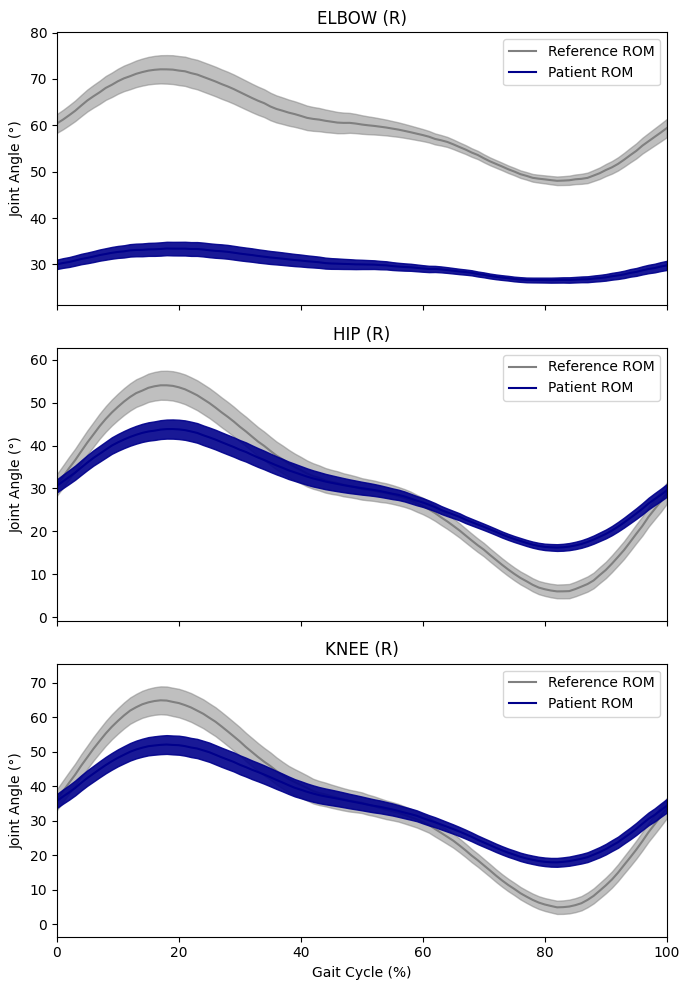

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# 1) DATA GENERATION
###############################################################################

# Create a gait cycle from 0 to 100 (101 points)
gait_cycle = np.linspace(0, 100, 101)

def random_wave(gait, baseline, amp_main, amp_second, noise_scale=0.3):
    """
    Combine two sine waves + random noise for a more 'irregular' mean curve.
    """
    wave = (baseline
            + amp_main   * np.sin(2 * np.pi * gait / 100)   # 1st harmonic
            + amp_second * np.sin(4 * np.pi * gait / 100)   # 2nd harmonic
            + noise_scale * np.random.randn(len(gait)))     # random noise
    return wave

def variable_std(gait, base_std, amp_std):
    """
    Create a variable standard deviation curve over the gait cycle.
    """
    std_vals = base_std + amp_std * np.sin(2 * np.pi * gait / 100)
    return np.clip(std_vals, 0.2, None)

def smooth_cyclic(data, window_len=7):
    """
    Smooth data in a 'cyclic' way so that the start and end points match up.
    """
    half = window_len // 2
    extended = np.concatenate([data[-half:], data, data[:half]])
    kernel = np.ones(window_len) / window_len
    smoothed_ext = np.convolve(extended, kernel, mode='same')
    smoothed = smoothed_ext[half:-half]
    return smoothed

# -----------------------------------------------------------------------------
# ELBOW (R)
# -----------------------------------------------------------------------------
elbow_ref_mean = random_wave(gait_cycle, baseline=60, amp_main=10, amp_second=4, noise_scale=0.3)
elbow_ref_std  = variable_std(gait_cycle, base_std=2.0, amp_std=1.2)

elbow_pat_mean = random_wave(gait_cycle, baseline=60, amp_main=3,  amp_second=1, noise_scale=0.2)
elbow_pat_std  = variable_std(gait_cycle, base_std=1.0, amp_std=0.5)

elbow_ref_mean = smooth_cyclic(elbow_ref_mean, window_len=7)
elbow_ref_std  = smooth_cyclic(elbow_ref_std,  window_len=7)
elbow_pat_mean = smooth_cyclic(elbow_pat_mean, window_len=7)
elbow_pat_std  = smooth_cyclic(elbow_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# HIP (R)
# -----------------------------------------------------------------------------
hip_ref_mean = random_wave(gait_cycle, baseline=30, amp_main=20, amp_second=8, noise_scale=0.3)
hip_ref_std  = variable_std(gait_cycle, base_std=2.5, amp_std=1.0)

hip_pat_mean = random_wave(gait_cycle, baseline=30, amp_main=12, amp_second=4, noise_scale=0.2)
hip_pat_std  = variable_std(gait_cycle, base_std=1.5, amp_std=0.8)

hip_ref_mean = smooth_cyclic(hip_ref_mean, window_len=7)
hip_ref_std  = smooth_cyclic(hip_ref_std,  window_len=7)
hip_pat_mean = smooth_cyclic(hip_pat_mean, window_len=7)
hip_pat_std  = smooth_cyclic(hip_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# KNEE (R)
# -----------------------------------------------------------------------------
knee_ref_mean = random_wave(gait_cycle, baseline=35, amp_main=25, amp_second=10, noise_scale=0.4)
knee_ref_std  = variable_std(gait_cycle, base_std=3.0, amp_std=1.2)

knee_pat_mean = random_wave(gait_cycle, baseline=35, amp_main=15, amp_second=5, noise_scale=0.3)
knee_pat_std  = variable_std(gait_cycle, base_std=2.0, amp_std=0.8)

knee_ref_mean = smooth_cyclic(knee_ref_mean, window_len=7)
knee_ref_std  = smooth_cyclic(knee_ref_std,  window_len=7)
knee_pat_mean = smooth_cyclic(knee_pat_mean, window_len=7)
knee_pat_std  = smooth_cyclic(knee_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# 2) SAVE TO CSV
# -----------------------------------------------------------------------------
df = pd.DataFrame({
    "Gait_Cycle(%)": gait_cycle,

    "Elbow_Reference_Mean": elbow_ref_mean,
    "Elbow_Reference_Std":  elbow_ref_std,
    "Elbow_Patient_Mean":   elbow_pat_mean,
    "Elbow_Patient_Std":    elbow_pat_std,

    "Hip_Reference_Mean":   hip_ref_mean,
    "Hip_Reference_Std":    hip_ref_std,
    "Hip_Patient_Mean":     hip_pat_mean,
    "Hip_Patient_Std":      hip_pat_std,

    "Knee_Reference_Mean":  knee_ref_mean,
    "Knee_Reference_Std":   knee_ref_std,
    "Knee_Patient_Mean":    knee_pat_mean,
    "Knee_Patient_Std":     knee_pat_std
})

# Compute the current mean of the Elbow Patient data and adjust to a target mean
current_mean = df['Elbow_Patient_Mean'].mean()
target_mean = 30
offset = current_mean - target_mean
df['Elbow_Patient_Mean'] = df['Elbow_Patient_Mean'] - offset

csv_filename = "rom_data_synthetic_smoothed.csv"
df.to_csv(csv_filename, index=False)
print(f"Synthetic, cyclic-smoothed ROM data saved to {csv_filename}")

###############################################################################
# 3) PLOT THE RESULTS
###############################################################################
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

def plot_joint(ax, joint_name, color_patient="#00008B", color_ref="gray"):
    """
    Plot the joint data with a tighter y-axis.
    """
    ref_mean_col = f"{joint_name}_Reference_Mean"
    ref_std_col  = f"{joint_name}_Reference_Std"
    pat_mean_col = f"{joint_name}_Patient_Mean"
    pat_std_col  = f"{joint_name}_Patient_Std"

    ref_mean = df[ref_mean_col]
    ref_std  = df[ref_std_col]
    pat_mean = df[pat_mean_col]
    pat_std  = df[pat_std_col]

    ax.set_axisbelow(True)

    # Plot Reference (behind)
    ax.plot(gait_cycle, ref_mean, color=color_ref, alpha=1.0, label="Reference ROM", zorder=1)
    ax.fill_between(gait_cycle, ref_mean - ref_std, ref_mean + ref_std,
                    color=color_ref, alpha=0.5, zorder=1)

    # Plot Patient (in front)
    ax.plot(gait_cycle, pat_mean, color=color_patient, alpha=1.0, label="Patient ROM", zorder=2)
    ax.fill_between(gait_cycle, pat_mean - pat_std, pat_mean + pat_std,
                    color=color_patient, alpha=0.9, zorder=2)

    ax.set_ylabel("Joint Angle (°)")
    ax.set_title(f"{joint_name.upper()} (R)")
    ax.legend(loc="best")
    
    # Calculate data range and add a 10% margin for a tighter y-axis
    data_min = min((ref_mean - ref_std).min(), (pat_mean - pat_std).min())
    data_max = max((ref_mean + ref_std).max(), (pat_mean + pat_std).max())
    margin = 0.1 * (data_max - data_min) if data_max != data_min else 1
    ax.set_ylim(data_min - margin, data_max + margin)

# Plot each joint
plot_joint(axes[0], "Elbow")
plot_joint(axes[1], "Hip")
plot_joint(axes[2], "Knee")

# Set x-axis limits and ticks for all subplots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))

# Label the shared x-axis
axes[-1].set_xlabel("Gait Cycle (%)")

plt.tight_layout()
plt.show()


Synthetic, cyclic-smoothed ROM data saved to rom_data_synthetic_smoothed.csv


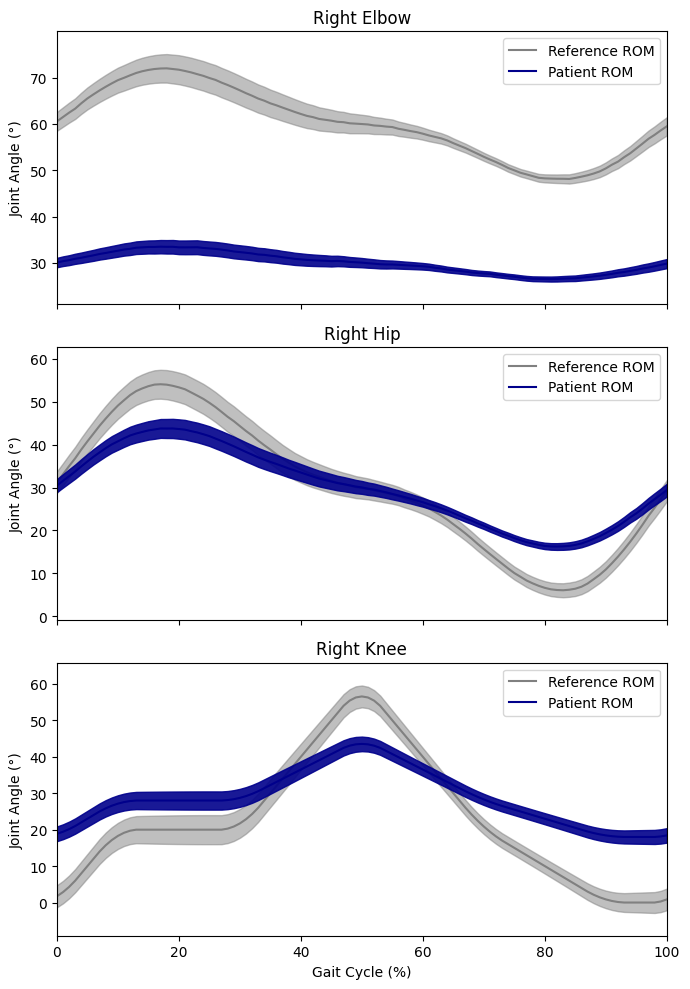

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# 1) DATA GENERATION
###############################################################################

# Create a gait cycle from 0 to 100 (101 points)
gait_cycle = np.linspace(0, 100, 101)

def random_wave(gait, baseline, amp_main, amp_second, noise_scale=0.3):
    """
    Combine two sine waves + random noise for a more 'irregular' mean curve.
    """
    wave = (baseline
            + amp_main   * np.sin(2 * np.pi * gait / 100)   # 1st harmonic
            + amp_second * np.sin(4 * np.pi * gait / 100)   # 2nd harmonic
            + noise_scale * np.random.randn(len(gait)))     # random noise
    return wave

def variable_std(gait, base_std, amp_std):
    """
    Create a variable standard deviation curve over the gait cycle.
    """
    std_vals = base_std + amp_std * np.sin(2 * np.pi * gait / 100)
    return np.clip(std_vals, 0.2, None)

def smooth_cyclic(data, window_len=7):
    """
    Smooth data in a 'cyclic' way so that the start and end points match up.
    """
    half = window_len // 2
    extended = np.concatenate([data[-half:], data, data[:half]])
    kernel = np.ones(window_len) / window_len
    smoothed_ext = np.convolve(extended, kernel, mode='same')
    smoothed = smoothed_ext[half:-half]
    return smoothed

# -----------------------------------------------------------------------------
# ELBOW (R)
# -----------------------------------------------------------------------------
elbow_ref_mean = random_wave(gait_cycle, baseline=60, amp_main=10, amp_second=4, noise_scale=0.3)
elbow_ref_std  = variable_std(gait_cycle, base_std=2.0, amp_std=1.2)

elbow_pat_mean = random_wave(gait_cycle, baseline=60, amp_main=3, amp_second=1, noise_scale=0.2)
elbow_pat_std  = variable_std(gait_cycle, base_std=1.0, amp_std=0.5)

elbow_ref_mean = smooth_cyclic(elbow_ref_mean, window_len=7)
elbow_ref_std  = smooth_cyclic(elbow_ref_std,  window_len=7)
elbow_pat_mean = smooth_cyclic(elbow_pat_mean, window_len=7)
elbow_pat_std  = smooth_cyclic(elbow_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# HIP (R)
# -----------------------------------------------------------------------------
hip_ref_mean = random_wave(gait_cycle, baseline=30, amp_main=20, amp_second=8, noise_scale=0.3)
hip_ref_std  = variable_std(gait_cycle, base_std=2.5, amp_std=1.0)

hip_pat_mean = random_wave(gait_cycle, baseline=30, amp_main=12, amp_second=4, noise_scale=0.2)
hip_pat_std  = variable_std(gait_cycle, base_std=1.5, amp_std=0.8)

hip_ref_mean = smooth_cyclic(hip_ref_mean, window_len=7)
hip_ref_std  = smooth_cyclic(hip_ref_std,  window_len=7)
hip_pat_mean = smooth_cyclic(hip_pat_mean, window_len=7)
hip_pat_std  = smooth_cyclic(hip_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# KNEE (R) with variable fluctuations in width
# -----------------------------------------------------------------------------
# 1) Reference wave: starts at 0, climbs to 20, stays ~20, goes up to 60, returns to 0
knee_ref_x = [0, 10, 30, 50, 70, 90, 100]
knee_ref_y = [0, 20, 20, 60, 20,  0,   0]
knee_ref_mean = np.interp(gait_cycle, knee_ref_x, knee_ref_y)
# Use variable_std for fluctuating width instead of a constant
knee_ref_std  = variable_std(gait_cycle, base_std=3.0, amp_std=1.0)

# 2) Patient wave: starts around 18, follows same shape but with reduced amplitude
knee_pat_x = [0, 10, 30, 50, 70, 90, 100]
knee_pat_y = [18, 28, 28, 45, 28, 18, 18]
knee_pat_mean = np.interp(gait_cycle, knee_pat_x, knee_pat_y)
knee_pat_std  = variable_std(gait_cycle, base_std=2.0, amp_std=0.5)

# Optionally smooth them cyclically to remove sharp edges
knee_ref_mean = smooth_cyclic(knee_ref_mean, window_len=7)
knee_ref_std  = smooth_cyclic(knee_ref_std,  window_len=7)
knee_pat_mean = smooth_cyclic(knee_pat_mean, window_len=7)
knee_pat_std  = smooth_cyclic(knee_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# 2) SAVE TO CSV
# -----------------------------------------------------------------------------
df = pd.DataFrame({
    "Gait_Cycle(%)": gait_cycle,

    "Elbow_Reference_Mean": elbow_ref_mean,
    "Elbow_Reference_Std":  elbow_ref_std,
    "Elbow_Patient_Mean":   elbow_pat_mean,
    "Elbow_Patient_Std":    elbow_pat_std,

    "Hip_Reference_Mean":   hip_ref_mean,
    "Hip_Reference_Std":    hip_ref_std,
    "Hip_Patient_Mean":     hip_pat_mean,
    "Hip_Patient_Std":      hip_pat_std,

    "Knee_Reference_Mean":  knee_ref_mean,
    "Knee_Reference_Std":   knee_ref_std,
    "Knee_Patient_Mean":    knee_pat_mean,
    "Knee_Patient_Std":     knee_pat_std
})

# (Optional) Shift Elbow Patient data to a target mean, e.g. 30
current_mean = df['Elbow_Patient_Mean'].mean()
target_mean = 30
offset = current_mean - target_mean
df['Elbow_Patient_Mean'] = df['Elbow_Patient_Mean'] - offset

csv_filename = "rom_data_synthetic_smoothed.csv"
df.to_csv(csv_filename, index=False)
print(f"Synthetic, cyclic-smoothed ROM data saved to {csv_filename}")

###############################################################################
# 3) PLOT THE RESULTS
###############################################################################
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

def plot_joint(ax, joint_name, color_patient="#00008B", color_ref="gray", title=""):
    """
    Plot the joint data with a tighter y-axis.
    """
    ref_mean_col = f"{joint_name}_Reference_Mean"
    ref_std_col  = f"{joint_name}_Reference_Std"
    pat_mean_col = f"{joint_name}_Patient_Mean"
    pat_std_col  = f"{joint_name}_Patient_Std"

    ref_mean = df[ref_mean_col]
    ref_std  = df[ref_std_col]
    pat_mean = df[pat_mean_col]
    pat_std  = df[pat_std_col]

    ax.set_axisbelow(True)

    # Plot Reference (behind)
    ax.plot(gait_cycle, ref_mean, color=color_ref, alpha=1.0, label="Reference ROM", zorder=1)
    ax.fill_between(gait_cycle, ref_mean - ref_std, ref_mean + ref_std,
                    color=color_ref, alpha=0.5, zorder=1)

    # Plot Patient (in front)
    ax.plot(gait_cycle, pat_mean, color=color_patient, alpha=1.0, label="Patient ROM", zorder=2)
    ax.fill_between(gait_cycle, pat_mean - pat_std, pat_mean + pat_std,
                    color=color_patient, alpha=0.9, zorder=2)

    ax.set_ylabel("Joint Angle (°)")
    ax.set_title(title)
    ax.legend(loc="best")
    
    # Calculate data range and add a 10% margin for a tighter y-axis
    data_min = min((ref_mean - ref_std).min(), (pat_mean - pat_std).min())
    data_max = max((ref_mean + ref_std).max(), (pat_mean + pat_std).max())
    margin = 0.1 * (data_max - data_min) if data_max != data_min else 1
    ax.set_ylim(data_min - margin, data_max + margin)

# Plot each joint with new titles
plot_joint(axes[0], "Elbow", title="Right Elbow")
plot_joint(axes[1], "Hip",   title="Right Hip")
plot_joint(axes[2], "Knee",  title="Right Knee")

# Set x-axis limits and ticks for all subplots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))

# Label the shared x-axis
axes[-1].set_xlabel("Gait Cycle (%)")

plt.tight_layout()
plt.show()


Synthetic, cyclic-smoothed ROM data saved to rom_data_synthetic_smoothed.csv


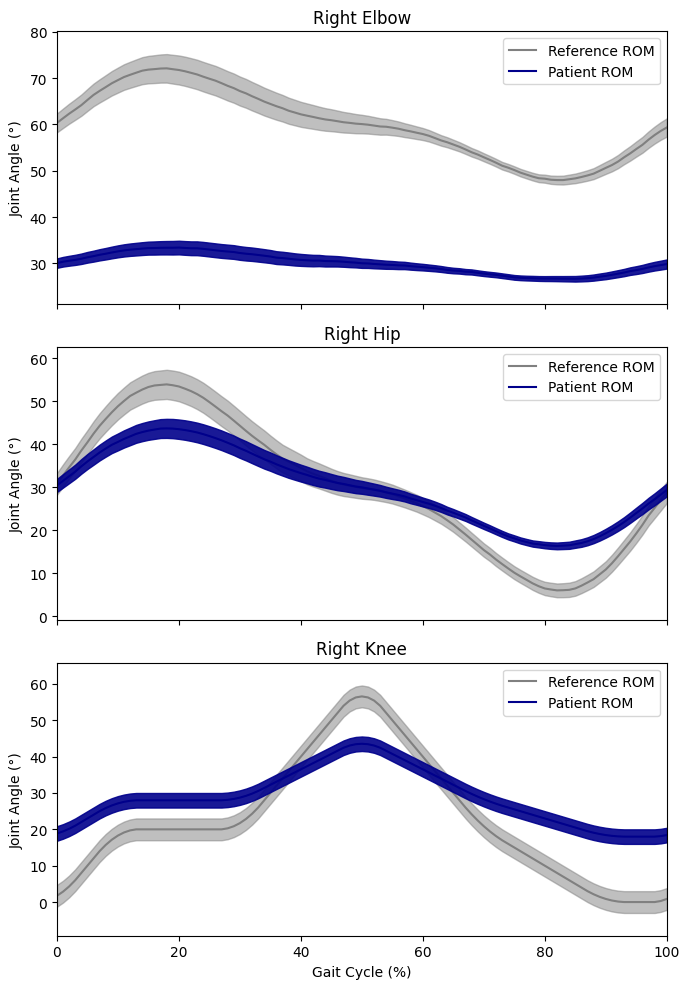

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# 1) DATA GENERATION
###############################################################################

# Create a gait cycle from 0 to 100 (101 points)
gait_cycle = np.linspace(0, 100, 101)

def random_wave(gait, baseline, amp_main, amp_second, noise_scale=0.3):
    """
    Combine two sine waves + random noise for a more 'irregular' mean curve.
    """
    wave = (baseline
            + amp_main   * np.sin(2 * np.pi * gait / 100)   # 1st harmonic
            + amp_second * np.sin(4 * np.pi * gait / 100)   # 2nd harmonic
            + noise_scale * np.random.randn(len(gait)))     # random noise
    return wave

def variable_std(gait, base_std, amp_std):
    """
    Create a variable standard deviation curve over the gait cycle.
    """
    std_vals = base_std + amp_std * np.sin(2 * np.pi * gait / 100)
    return np.clip(std_vals, 0.2, None)

def smooth_cyclic(data, window_len=7):
    """
    Smooth data in a 'cyclic' way so that the start and end points match up.
    """
    half = window_len // 2
    extended = np.concatenate([data[-half:], data, data[:half]])
    kernel = np.ones(window_len) / window_len
    smoothed_ext = np.convolve(extended, kernel, mode='same')
    smoothed = smoothed_ext[half:-half]
    return smoothed

# -----------------------------------------------------------------------------
# ELBOW (R)
# -----------------------------------------------------------------------------
elbow_ref_mean = random_wave(gait_cycle, baseline=60, amp_main=10, amp_second=4, noise_scale=0.3)
elbow_ref_std  = variable_std(gait_cycle, base_std=2.0, amp_std=1.2)

elbow_pat_mean = random_wave(gait_cycle, baseline=60, amp_main=3,  amp_second=1, noise_scale=0.2)
elbow_pat_std  = variable_std(gait_cycle, base_std=1.0, amp_std=0.5)

# Smooth them cyclically
elbow_ref_mean = smooth_cyclic(elbow_ref_mean, window_len=7)
elbow_ref_std  = smooth_cyclic(elbow_ref_std,  window_len=7)
elbow_pat_mean = smooth_cyclic(elbow_pat_mean, window_len=7)
elbow_pat_std  = smooth_cyclic(elbow_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# HIP (R)
# -----------------------------------------------------------------------------
hip_ref_mean = random_wave(gait_cycle, baseline=30, amp_main=20, amp_second=8, noise_scale=0.3)
hip_ref_std  = variable_std(gait_cycle, base_std=2.5, amp_std=1.0)

hip_pat_mean = random_wave(gait_cycle, baseline=30, amp_main=12, amp_second=4, noise_scale=0.2)
hip_pat_std  = variable_std(gait_cycle, base_std=1.5, amp_std=0.8)

hip_ref_mean = smooth_cyclic(hip_ref_mean, window_len=7)
hip_ref_std  = smooth_cyclic(hip_ref_std,  window_len=7)
hip_pat_mean = smooth_cyclic(hip_pat_mean, window_len=7)
hip_pat_std  = smooth_cyclic(hip_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# KNEE (R)
# -----------------------------------------------------------------------------
# 1) Reference wave: starts at 0, climbs to 20, stays ~20, goes up to 60, returns to 0
#    (Piecewise linear interpolation over key points)
knee_ref_x = [0, 10, 30, 50, 70, 90, 100]
knee_ref_y = [0, 20, 20, 60, 20,  0,   0]
knee_ref_mean = np.interp(gait_cycle, knee_ref_x, knee_ref_y)
knee_ref_std  = np.full_like(gait_cycle, 3.0)  # constant ±3°

# 2) Patient wave: starts around 18, follows same shape but with reduced amplitude
knee_pat_x = [0, 10, 30, 50, 70, 90, 100]
knee_pat_y = [18, 28, 28, 45, 28, 18, 18]
knee_pat_mean = np.interp(gait_cycle, knee_pat_x, knee_pat_y)
knee_pat_std  = np.full_like(gait_cycle, 2.0)  # constant ±2°

# Optionally smooth them cyclically to remove sharp edges
knee_ref_mean = smooth_cyclic(knee_ref_mean, window_len=7)
knee_ref_std  = smooth_cyclic(knee_ref_std,  window_len=7)
knee_pat_mean = smooth_cyclic(knee_pat_mean, window_len=7)
knee_pat_std  = smooth_cyclic(knee_pat_std,  window_len=7)

# -----------------------------------------------------------------------------
# 2) SAVE TO CSV
# -----------------------------------------------------------------------------
df = pd.DataFrame({
    "Gait_Cycle(%)": gait_cycle,

    "Elbow_Reference_Mean": elbow_ref_mean,
    "Elbow_Reference_Std":  elbow_ref_std,
    "Elbow_Patient_Mean":   elbow_pat_mean,
    "Elbow_Patient_Std":    elbow_pat_std,

    "Hip_Reference_Mean":   hip_ref_mean,
    "Hip_Reference_Std":    hip_ref_std,
    "Hip_Patient_Mean":     hip_pat_mean,
    "Hip_Patient_Std":      hip_pat_std,

    "Knee_Reference_Mean":  knee_ref_mean,
    "Knee_Reference_Std":   knee_ref_std,
    "Knee_Patient_Mean":    knee_pat_mean,
    "Knee_Patient_Std":     knee_pat_std
})

# (Optional) Shift Elbow Patient data to a target mean, e.g. 30
current_mean = df['Elbow_Patient_Mean'].mean()
target_mean = 30
offset = current_mean - target_mean
df['Elbow_Patient_Mean'] = df['Elbow_Patient_Mean'] - offset

csv_filename = "rom_data_synthetic_smoothed.csv"
df.to_csv(csv_filename, index=False)
print(f"Synthetic, cyclic-smoothed ROM data saved to {csv_filename}")

###############################################################################
# 3) PLOT THE RESULTS
###############################################################################
fig, axes = plt.subplots(3, 1, figsize=(7, 10), sharex=True)

def plot_joint(ax, joint_name, color_patient="#00008B", color_ref="gray", title=""):
    """
    Plot the joint data with a tighter y-axis.
    """
    ref_mean_col = f"{joint_name}_Reference_Mean"
    ref_std_col  = f"{joint_name}_Reference_Std"
    pat_mean_col = f"{joint_name}_Patient_Mean"
    pat_std_col  = f"{joint_name}_Patient_Std"

    ref_mean = df[ref_mean_col]
    ref_std  = df[ref_std_col]
    pat_mean = df[pat_mean_col]
    pat_std  = df[pat_std_col]

    ax.set_axisbelow(True)

    # Plot Reference (behind)
    ax.plot(gait_cycle, ref_mean, color=color_ref, alpha=1.0, label="Reference ROM", zorder=1)
    ax.fill_between(gait_cycle, ref_mean - ref_std, ref_mean + ref_std,
                    color=color_ref, alpha=0.5, zorder=1)

    # Plot Patient (in front)
    ax.plot(gait_cycle, pat_mean, color=color_patient, alpha=1.0, label="Patient ROM", zorder=2)
    ax.fill_between(gait_cycle, pat_mean - pat_std, pat_mean + pat_std,
                    color=color_patient, alpha=0.9, zorder=2)

    ax.set_ylabel("Joint Angle (°)")
    ax.set_title(title)
    ax.legend(loc="best")
    
    # Calculate data range and add a 10% margin for a tighter y-axis
    data_min = min((ref_mean - ref_std).min(), (pat_mean - pat_std).min())
    data_max = max((ref_mean + ref_std).max(), (pat_mean + pat_std).max())
    margin = 0.1 * (data_max - data_min) if data_max != data_min else 1
    ax.set_ylim(data_min - margin, data_max + margin)

# Plot each joint with new titles
plot_joint(axes[0], "Elbow", title="Right Elbow")
plot_joint(axes[1], "Hip",   title="Right Hip")
plot_joint(axes[2], "Knee",  title="Right Knee")

# Set x-axis limits and ticks for all subplots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 20))

# Label the shared x-axis
axes[-1].set_xlabel("Gait Cycle (%)")

plt.tight_layout()
plt.show()
